## Introdução Prática à Previsão Conforme

Previsão Conforme (em inglês Conformal Prediction) é um método que transforma as previsões pontuais em conjuntos de previsões. Dessa forma, fornece previsões associadas à um nível de confiança estatística, permitindo que sejam medidos e controlados os riscos de uma previsão estar errada.


### Importar Libs

In [1]:
#!pip install -U numpy

In [2]:
#!pip install mapie -use-deprecated=legacy-resolver

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import wget
import zipfile
from os.path import exists

import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from mapie.classification import MapieClassifier

### Download Dataset

In [4]:
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number = "00602"
filename = "DryBeanDataset.zip"
url = base + dataset_number + "/" + filename
wget.download(url)
zipfile.ZipFile(filename, 'r') .extractall('./')
os.remove(filename)

### Importar Dataset

In [5]:
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
beans = pd.read_excel(bean_data_file)

In [6]:
beans.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178,173.889,1.197,0.550,28715,190.141,0.764,0.989,0.958,0.913,0.007,0.003,0.834,0.999,SEKER
1,28734,638.018,200.525,182.734,1.097,0.412,29172,191.273,0.784,0.985,0.887,0.954,0.007,0.004,0.910,0.998,SEKER
2,29380,624.110,212.826,175.931,1.210,0.563,29690,193.411,0.778,0.990,0.948,0.909,0.007,0.003,0.826,0.999,SEKER
3,30008,645.884,210.558,182.517,1.154,0.499,30724,195.467,0.783,0.977,0.904,0.928,0.007,0.003,0.862,0.994,SEKER
4,30140,620.134,201.848,190.279,1.061,0.334,30417,195.897,0.773,0.991,0.985,0.971,0.007,0.004,0.942,0.999,SEKER


### Pre-Process and Train Model

In [7]:
# Labels are characters but should be integers for sklearn
le = LabelEncoder()
beans["Class"] = le.fit_transform(beans["Class"])

# Split data into classification target and features
y = beans["Class"]
X = beans.drop("Class", axis = 1)

# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=10000, random_state=2)

# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=1000, random_state=42)

# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=42)

# Fit the model
model = GaussianNB().fit(X_train, y_train)

### Model Evaluation

In [8]:
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))

Accuracy: 0.758
          BARBUNYA  BOMBAY  CALI  DERMASON  HOROZ  SEKER  SIRA
BARBUNYA        46       0    47         0      6      0     4
BOMBAY           0      33     0         0      0      0     0
CALI            20       0    81         0      3      0     0
DERMASON         0       0     0       223      0     32     9
HOROZ            0       0     4         3    104      0    22
SEKER            2       0     0        26      1    127    22
SIRA             0       0     0        10     10     21   144


### Model Calibration - Naive Approach

In [9]:
#Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)

# Get for each instance the highest probability
high_prob_predictions = np.amax(predictions, axis=1)

# Select the predictions where probability over 99%
high_p_beans = np.where(high_prob_predictions >= 0.95)

# Let's count how often we hit the right label
its_a_match = (model.predict(X_calib) == y_calib)
coverage = np.mean(its_a_match.values[high_p_beans])
print(round(coverage, 3))

0.896


### Model Calibration - Conformal Classification

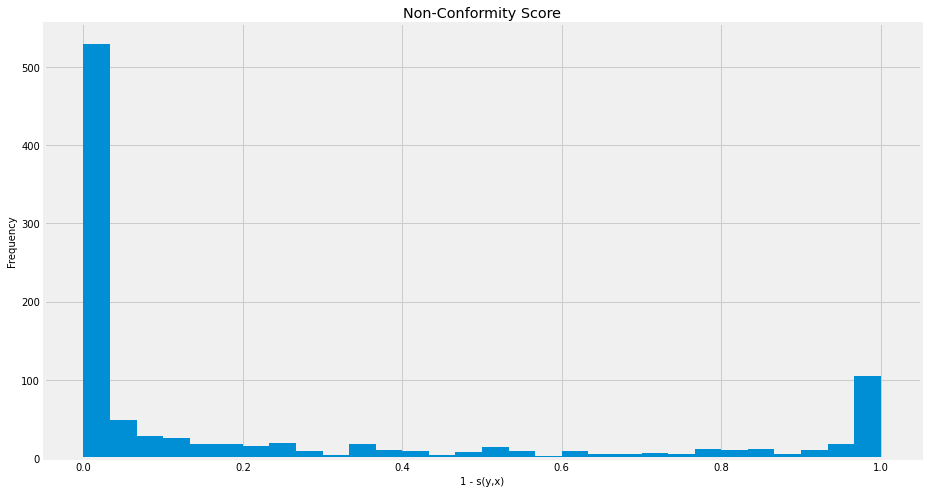

In [10]:
# Size of calibration data
n = len(X_calib)

# Get the probability predictions
predictions = model.predict_proba(X_calib)

# We only need the probability for the true class
prob_true_class = predictions[np.arange(n),y_calib]

# Turn into uncertainty score (larger means more uncertain)
scores = 1 - prob_true_class

# Setting the alpha so that we get 95% prediction sets
alpha = 0.05

# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level)

# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)

# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]

# Create a histogram
fig, axs = plt.subplots(figsize=(14, 8))
plt.hist(1 - prob_for_true_class, bins=30, range=(0, 1))
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")
plt.title("Non-Conformity Score")
plt.show()

### Model Calibration - Conformal Classification - Prediction Sets

In [11]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)
for i in range(3):
    print(le.classes_[prediction_sets[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']


### Model Calibration - Conformal Classification - MAPIE

In [12]:
cp = MapieClassifier(estimator=model, cv="prefit", method="score")
cp.fit(X_calib, y_calib)
y_pred, y_set = cp.predict(X_new, alpha=0.05)

In [13]:
y_set = np.squeeze(y_set)

for i in range(5):
    print(le.classes_[y_set[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']
['DERMASON']
['DERMASON' 'SEKER']


In [14]:
# first count number of classes per bean
set_sizes = y_set.sum(axis=1)

# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

2    871
1    506
3    233
4      1
dtype: int64


In [15]:
y_pred, y_set = cp.predict(X_new, alpha=0.01)

# remove the 1-dim dimension
y_set = np.squeeze(y_set)

# first count number of classes per bean
set_sizes = y_set.sum(axis=1)

# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

3    780
2    372
4    236
1    222
5      1
dtype: int64


In [16]:
y_pred, y_set = cp.predict(X_new, alpha=[0.1, 0.05])

# get prediction sets for 10th observation and second alpha (0.05)
print(le.classes_[y_set[10,:,1]])

['HOROZ' 'SIRA']


In [17]:
y_pred, y_set = cp.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)
df = pd.DataFrame()

for i in range(len(y_pred)):
    predset = le.classes_[y_set[i]]
    
    # Create a new dataframe with the calculated values
    temp_df = pd.DataFrame({
        "set": [predset],
        "setsize": [len(predset)]
        },
        index=[i])
    
    # Concatenate the new dataframe with the existing one
    df = pd.concat([df, temp_df])
    
df.head()

,set,setsize
0,[DERMASON],1
1,[DERMASON],1
2,"[DERMASON, SEKER]",2
3,[DERMASON],1
4,"[DERMASON, SEKER]",2
